Inputs

In [9]:
import pygame
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import itertools
import threading
import queue
from io import BytesIO

# a parede é um cubo/quadrado determinado pelo tamanho do lado do cubo/quadrado e numero de dimensoes
tamanho_parede: float      = 400 # nm
tamanho_celula_grid: float = 0.5 * tamanho_parede

numero_dimensoes: int       = 2
capacidade_maxima: int      = 101
qtd_inicial_particulas: int = 35

raio:  float = 5 #0.250 #nm
massa: float = 1 #* 1.66053966e-15 #pg (picogramas)

velocidade_maxima: float = 25 #nm/ns

tempo_global = 0   # ns
tempo_frame  = 0.2 # ns
tempo_sample = 2   # ns

# Cores
preto  = (0, 0, 0)
branco = (255, 255, 255)
cinza  = (200, 200, 200)

# tela de simulação
WIDTH, HEIGHT = 1200, 800
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Simulador")
screen.fill("White")

tela_simulacao = pygame.Surface((tamanho_parede, tamanho_parede))

# loop so pra impedir de tudo explodir
pygame.init()
pygame.font.init()

# Loop de simulacao
clock = pygame.time.Clock()
running = True

while running:
    tela_simulacao.fill(cinza)
    screen.blit(tela_simulacao,(0.06 * WIDTH, (HEIGHT - tamanho_parede)//2))

    # eventos
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    pygame.display.flip()
    clock.tick(60)

pygame.quit()

Classe particulas

In [10]:
# classe particula
class Particula:
    def __init__(self, raio: float, massa: float, vetor_posicao: list[float], vetor_velocidade: list[float]) -> None:
        self.massa = float(np.float64(massa))
        self.raio  = float(np.float64(raio))
        self.vetor_posicao    = np.array(vetor_posicao, dtype= np.float64)
        self.vetor_velocidade = np.array(vetor_velocidade, dtype= np.float64)
        self.momento_dado_paredes = 0

    @property
    def momento(self) -> npt.NDArray[np.float64]:
        """Retorna um ndarray dado por: massa * velocidade"""
        return self.massa * self.vetor_velocidade
    
    @property
    def energia_cinetica(self) -> np.float64:
        """Retorna um float64 dado por: massa * <velocidade, velocidade>"""
        return self.massa * np.vdot(self.vetor_velocidade, self.vetor_velocidade)
    

    def atualizar_posicao(self, tempo_decorrido: np.float64) -> None:
        """Usa a equação horária do movimento da partícula para atualizar sua posição um delta_t e colide elasticamente com as paredes"""
        self.vetor_posicao += self.vetor_velocidade * tempo_decorrido

        # Colisões com paredes (eixo X)
        if self.vetor_posicao[0] - self.raio <= 0:
            self.vetor_posicao[0] = self.raio
            self.vetor_velocidade[0] *= -1

        elif self.vetor_posicao[0] + self.raio >= tamanho_parede:
            self.vetor_posicao[0] = tamanho_parede - self.raio
            self.vetor_velocidade[0] *= -1
        
        self.momento_dado_paredes += abs(self.momento[0])

        # Colisões com paredes (eixo Y)
        if self.vetor_posicao[1] - self.raio <= 0:
            self.vetor_posicao[1] = self.raio
            self.vetor_velocidade[1] *= -1

        elif self.vetor_posicao[1] + self.raio >= tamanho_parede:
            self.vetor_posicao[1] = tamanho_parede - self.raio
            self.vetor_velocidade[1] *= -1
        
        self.momento_dado_paredes += abs(self.momento[1])

    def desenhar(self, superficie, cor):
        pygame.draw.circle(superficie, cor, (int(self.vetor_posicao[0]), int(self.vetor_posicao[1])),  self.raio)

    def __str__(self) -> str:
        return "Raio {}, massa {}, posicao {} e velocidade {}".format(self.raio, self.massa, self.vetor_posicao, self.vetor_velocidade)
    
    def __repr__(self) -> str:
        return "Particula({}, {}, {}, {})".format(self.raio, self.massa, self.vetor_posicao.tolist(), self.vetor_velocidade.tolist())


Funções usadas

In [11]:
# calcula nova velocidade das particulas depois de colidirem
def velocidades_apos_colisao(massas: list[float], velocidades_normais: list[np.float64]) -> list[np.float64]:
    """
    No momento da colisão, podemos decompor as velocidades das partículas em suas componentes normal ao impacto (v1 e v2) e tangencial. Somente a velocidade normal é alterada.\n
    v1_nova = ( (m1 - m2) v1 +   2 m2    v2 ) / (m1 + m2)\n
    v2_nova = (   2 m1    v1 + (m1 - m2) v2 ) / (m1 + m2)

    Returns
    -------
    lista_velocidades_novas: list[float64]
        É uma lista formada pelas velocidades normais novas calculadas, na forma  [v1_nova, v2_nova]
    """
    m1, m2 = massas
    v1, v2 = velocidades_normais
    
    diff_massa = m1 - m2
    soma_massa = m1 + m2

    velocidade_1_nova = (diff_massa * v1 +    2*m2    * v2) / soma_massa
    velocidade_2_nova = (   2*m1    * v1 + diff_massa * v2) / soma_massa

    return [velocidade_1_nova, velocidade_2_nova]

# colide e atualiza as particulas para a colisao
def colisao(particula_1: Particula, particula_2: Particula) -> None: # O(1)
    """
    Atualiza as velocidades das partículas durante uma colisão. Usar somente se a colisão já for confirmada.\n
    Para mudar a velocidade normal sem alterar a velocidade tangencial, o vetor normal é usado para alterar somente em relação à normal:\n\n
    velocidade_normal     = <velocidade_antes, vetor_normal>\n

    velocidade_antes  = velocidade_tangencial + velocidade_normal\n
    velocidade_depois = velocidade_tangencial + velocidade_normal_nova\n

    velocidade_nova = velocidade_antes + (v_normal_novo - v_normal_antes) * vetor_normal
    """
    vetor_distancia = particula_2.vetor_posicao - particula_1.vetor_posicao
    distancia = np.linalg.norm(vetor_distancia)

    if distancia < particula_1.raio + particula_2.raio:
        vetor_normal = vetor_distancia / distancia

        massa_1 = particula_1.massa
        massa_2 = particula_2.massa 

        v1_normal = np.vdot(particula_1.vetor_velocidade, vetor_normal)
        v2_normal = np.vdot(particula_2.vetor_velocidade, vetor_normal)

        v1_normal_novo, v2_normal_novo = velocidades_apos_colisao(massas = [massa_1, massa_2], velocidades_normais = [v1_normal, v2_normal])

        # Atualização das velocidades
        particula_1.vetor_velocidade += (v1_normal_novo - v1_normal) * vetor_normal
        particula_2.vetor_velocidade += (v2_normal_novo - v2_normal) * vetor_normal

        # Afasta as particulas pra evitar grudarem
        overlap = (particula_1.raio + particula_2.raio) - distancia
        particula_1.vetor_posicao -= (overlap/2) * vetor_normal
        particula_2.vetor_posicao += (overlap/2) * vetor_normal

# o RNG é um gerador aleatorio de float64 entre [0, 1)
rng = np.random.default_rng()
def vetor_aleatorio(valor_minimo: float, valor_maximo: float, dimensoes: int) -> npt.NDArray[np.float64]:
    """
    Gera um vetor (ndarray[float64]) com as dimensões dadas, com valores entre valor_minimo e valor_maximo, não inclusivo. Isso é para não ter problemas como iniciar na posição 0 (em colisão com parede)
    
    Returns
    -------
    vetor_aleatorio: ndarray[float64]
        Um vetor de dimensões dadas entre valor_minimo e valor_maximo, não inclusivo.
    """
    vetor_zero_a_um = rng.random(dimensoes)
    
    while min(vetor_zero_a_um) == 0:
        vetor_zero_a_um[vetor_zero_a_um == 0] = rng.random() # remapeia valores nulos, se tiver
    
    vetor_aleatorio = (valor_maximo - valor_minimo) * vetor_zero_a_um + valor_minimo

    return vetor_aleatorio

# criador de particula com posicao e velocidade aleatorias
def criar_particula_aleatoria(raio: float, massa: float) -> Particula:
    """
    Returns
    -------
    particula_criada: Particula
        Uma partícula com raio e massa dados pelo usuário e a posição e a velocidade aleatorizadas (distribuição uniforme)
    """
    posicao_minima    = 0 + raio
    posicao_maxima    = tamanho_parede - raio
    velocidade_minima = - velocidade_maxima # velocidades podem ser positivas ou negativas

    posicao_criada    = vetor_aleatorio(posicao_minima, posicao_maxima, numero_dimensoes)
    velocidade_criada = vetor_aleatorio(velocidade_minima, velocidade_maxima, numero_dimensoes)

    particula_criada = Particula(raio, massa, posicao_criada, velocidade_criada)
    return particula_criada

# criador da lista de partículas
def criar_particulas_iniciais(quantidade_particulas: int, raio: float, massa: float) -> list[Particula]: 
    """Usa a função criar_particula_aleatoria para criar a uma lista com a quantidade de partículas desejada, ajustando as velocidades de todas pro momento ser zero no final"""
    # primeiro monta uma lista inicial das particulas
    lista_particulas = [criar_particula_aleatoria(raio, massa) for i in range(quantidade_particulas)]
    
    lista_velocidades = [particula.vetor_velocidade for particula in lista_particulas]
    velocidade_para_somar = - np.sum(lista_velocidades, axis=0) / (quantidade_particulas - 1)

    for i in range(quantidade_particulas - 1):
        particula = lista_particulas[i]
        nova_velocidade = particula.vetor_velocidade + velocidade_para_somar
        lista_particulas[i] = Particula(raio, massa, particula.vetor_posicao, nova_velocidade)

    # e a ultima particula recebe o valor que falta para o momento ser zero
    lista_velocidades = [particula.vetor_velocidade for particula in lista_particulas]

    posicao_ultima_particula = lista_particulas[-1].vetor_posicao
    velocidade_ultima_particula = lista_particulas[-1].vetor_velocidade - np.sum(lista_velocidades, axis=0)

    lista_particulas[-1] = Particula(raio, massa, posicao_ultima_particula, velocidade_ultima_particula)

    return lista_particulas


In [12]:
class Grid_simulacao:
    def __init__(self, vetor_dominio: list[float], tamanho_celula: float):
        """
        vetor_dominio: vetor da forma [limite_x, limite_y, limite_z] (2 ou 3 dimensoes)
        tamanho_celula: float (tamanho do lado da celula quadrada/cubica) 
        capacidade_maxima: int (alocação de memória)
        """
        self.vetor_dominio  = np.array(vetor_dominio)
        self.tamanho_celula = tamanho_celula
        self.contagem_particulas = 0

        # calcula quantas celulas cabem em cada dimensao
        self.vetor_quantidade_celulas = np.ceil(np.divide(vetor_dominio, tamanho_celula)).astype(np.int32)
        """Calcula quantas células serão precisas pra preencher cada dimensão."""
        self.total_celulas = np.prod(self.vetor_quantidade_celulas)

        # alocando memoria pra particulas
        self.particulas: list[Particula]   = np.empty(capacidade_maxima, dtype=object)
        """Lista para armazenar as partículas. Inicializada com None's."""
        self.particulas_ativas: list[bool] = np.zeros(capacidade_maxima, dtype=bool)
        """Lista de booleans que mostram rapidamente quais particulas de self.particulas estão em uso na simulação, para rapidamente adicionar/deletar partículas na simulação. Inicializado com zeros."""
        
        # pointers pras celulas individuais
        self.que_celula_pertence = np.zeros((capacidade_maxima, numero_dimensoes), dtype=np.int32)
        """Lista de vetores que mapeia a partícula da posição i em self.particulas aos índices (vetor 2d ou 3d) da célula a que pertence (ex.: a particula 3 pertence à célula [2,2,3]). Inicializada com vetores de zeros""" 
        self.lista_celulas_hash  = np.zeros(capacidade_maxima, dtype=np.int32)
        """Mapeamento dos índices de self.que_celula_pertence para índices únicos de cada célula (Ex.: a partícula 3 está na célula [indice_x, indice_y, indice_z], cujo hash é indice_x + indice_y * tamanho_celula + indice_z * tamanho_celula^2)"""
        
        self.indices_organizados = np.zeros(capacidade_maxima, dtype=np.int32)
        """Lista dos índices das partículas ordenadas em função dos hashes das células que pertencem. Podemos verificar todas as partículas em uma célula usando o primeiro e último índices que correspondem àquela célula. Inicializado com zeros."""
        self.primeiro_indice = -np.ones(self.total_celulas, dtype=np.int32)
        """Essa lista salva o primeiro índice das partículas ordenadas que correspondem às partículas na célula do hash correspondente da posição i da lista. Inicializado com -1's"""
        self.ultimo_indice   = -np.ones(self.total_celulas, dtype=np.int32)
        """Essa lista salva o último índice (menos 1) da partícula ordenadas que correspondem às partículas na célula do hash correspondente da posição i da lista. Inicializado com -1's"""

        # calculos pras celulas vizinhas
        self.offset_vizinhos = np.array(list(itertools.product([-1,0,1], repeat=numero_dimensoes)), dtype=np.int32)

    def adicionar_particulas(self, particulas_adicionar: list[Particula]):
        """Adiciona particulas ao grid de simulação"""
        if self.contagem_particulas + len(particulas_adicionar) >= capacidade_maxima:
            particulas_adicionar = particulas_adicionar[:capacidade_maxima - self.contagem_particulas - 1]
            self.contagem_particulas = capacidade_maxima
                
        for i, particula_i in enumerate(particulas_adicionar):
            indice = self.contagem_particulas + i
            self.particulas[indice] = particula_i
            self.particulas_ativas[indice] = True
            
        self.contagem_particulas += len(particulas_adicionar)
        self._recalcular_grid()

    def remover_particulas(self, quantas_particulas_remover: int):
        """Remove as ultimas n particulas da simulação."""
        if self.contagem_particulas - quantas_particulas_remover < 0:
            quantas_particulas_remover = self.contagem_particulas

        self.particulas_ativas[self.contagem_particulas - quantas_particulas_remover : self.contagem_particulas] = np.zeros(quantas_particulas_remover, dtype=bool)
        self.contagem_particulas -= quantas_particulas_remover
        self._recalcular_grid()

    def _atualizar_grid(self):
        """Recalcula as posições das partículas e a que célula cada partícula pertence, alem de recalcular o grid."""

        for i in range(self.contagem_particulas):
            if self.particulas_ativas[i]:
                posicao = self.particulas[i].vetor_posicao
                self.que_celula_pertence[i] = np.floor(np.divide(posicao, self.tamanho_celula)).astype(np.int32)
                
                np.clip(self.que_celula_pertence[i], np.zeros(numero_dimensoes).astype(np.int32), np.subtract(self.vetor_quantidade_celulas, 1).astype(np.int32), out=self.que_celula_pertence[i])

        self._recalcular_grid()

    def _recalcular_grid(self):
        """
        Faz o recalculo do grid, atualizando:\n
        - Que celulas estao com particulas (hash)\n
        - Os indices das particulas organizados em cada celula\n
        - O primeiro e ultimo indices das particulas em cada celula\n\n

        A utilizacao dessas variaveis é:\n
        indices_organizados[primeiro_indice[hash] : ultimo_indice[hash]] retorna todos os indices das particulas na celula do hash colocado
        """
        # primeiro reseta o grid
        self.primeiro_indice.fill(-1)
        self.ultimo_indice.fill(-1)

        if self.contagem_particulas == 0:
            return

        # coleta os indices das particulas ativas
        indices_particulas_ativas = np.where(self.particulas_ativas[:self.contagem_particulas])[0]

        if len(indices_particulas_ativas) == 0:
            return
        
        # verifica os hashes das células das particulas ativas
        self.lista_celulas_hash[indices_particulas_ativas] = np.ravel_multi_index(self.que_celula_pertence[indices_particulas_ativas].T, dims=self.vetor_quantidade_celulas)

        # Organiza as particulas (e as celulas) por hash de celula
        indices_organizados_por_celula = np.argsort(self.lista_celulas_hash[indices_particulas_ativas])
        self.indices_organizados[:len(indices_particulas_ativas)] = indices_particulas_ativas[indices_organizados_por_celula]

        celulas_organizadas_hash = self.lista_celulas_hash[self.indices_organizados[:len(indices_particulas_ativas)]]
        
        # Atualiza os indices das particulas nas celulas
        hashes_unicos, primeiro_indice_calculado = np.unique(celulas_organizadas_hash, return_index=True)
        self.primeiro_indice[hashes_unicos] = primeiro_indice_calculado
        self.ultimo_indice[hashes_unicos]   = np.append(primeiro_indice_calculado[1:], len(indices_particulas_ativas))

    def particulas_vizinhas(self, indice_particula):
        """Retorna todas as particulas nas celulas vizinhas (e na própria célula)."""
        if not self.particulas_ativas[indice_particula]:
            return []
            
        celula_que_pertence = self.que_celula_pertence[indice_particula]
        indices_celulas_vizinhas = np.add(celula_que_pertence, self.offset_vizinhos)

        indices_viaveis = list(itertools.filterfalse(
            lambda x: not all(0 <= x[i] < self.vetor_quantidade_celulas[i] for i in range(numero_dimensoes)),
            indices_celulas_vizinhas
            ))

        hashes_celulas_vizinhas = np.ravel_multi_index(np.array(indices_viaveis).T, self.vetor_quantidade_celulas)
        
        particulas_vizinhas = []
        for hash in hashes_celulas_vizinhas:
            primeiro_indice = self.primeiro_indice[hash]

            tem_particulas = (primeiro_indice != -1)
            if tem_particulas:
                ultimo_indice = self.ultimo_indice[hash]

                for indice in self.indices_organizados[primeiro_indice : ultimo_indice]:
                    if indice != indice_particula:  # se for ele mesmo, ignora
                        particulas_vizinhas.append(self.particulas[indice])
        
        return particulas_vizinhas

In [26]:
class HistogramRenderer:
    def __init__(self):
        self.render_queue = queue.Queue(maxsize=1)
        self.current_surface = None
        self.thread = threading.Thread(target=self._render_worker, daemon=True)
        self.thread.start()
        
    def _render_worker(self):
        """Background rendering thread"""
        dpi = 100  # Dots per inch
        fig_width  = 500 / dpi  # 500px ÷ 100dpi = 5 inches
        fig_height = 300 / dpi  # 300px ÷ 100dpi = 3 inches
        
        # Create figure with exact dimensions
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)  # Remove margins

        fig.patch.set_facecolor('#f0f0f0')
        ax.set_facecolor('#f0f0f0')
        plt.tight_layout()
        
        while True:
            data = self.render_queue.get()
            if data is None:  # Exit signal
                break
                
            ax.clear()
            ax.hist(data, bins=10, color='skyblue', edgecolor='none')

            ax.set_title("Distribuição de energias cinéticas", fontsize=12, pad=10)
            ax.set_xlabel('Energia cinética', fontsize=10)
            ax.set_ylabel('Frequência', fontsize=10)
            ax.set_ylim(0, 25)

            # Optimized rendering
            buf = BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1, dpi=100)
            buf.seek(0)
            self.current_surface = pygame.image.load(buf)
            
    def update_data(self, new_data):
        """Thread-safe data update"""
        try:
            self.render_queue.put_nowait(new_data)
        except queue.Full:
            pass
            
    def get_surface(self):
        """Get the latest rendered surface"""
        return self.current_surface

In [27]:
grid = Grid_simulacao(np.full(numero_dimensoes, tamanho_parede), tamanho_celula=tamanho_celula_grid)

grid.adicionar_particulas(criar_particulas_iniciais(qtd_inicial_particulas, raio, massa))
grid._atualizar_grid()

In [28]:
# declara essas variaveis
energias_cineticas = [particula.energia_cinetica for particula in grid.particulas[grid.particulas_ativas]]
momento_colisoes_parede = 0
energia_cinetica_media = np.mean([particula.energia_cinetica for particula in grid.particulas[grid.particulas_ativas]])

Loop de simulação

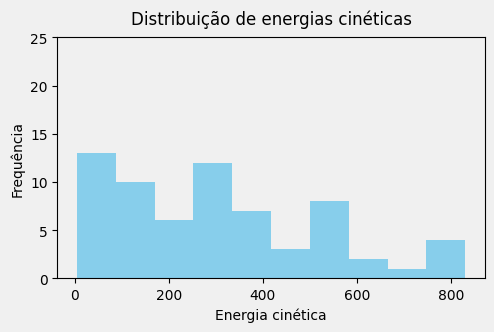

In [29]:
# tela de simulação
WIDTH, HEIGHT = 1200, 800
tamanho_histograma = (500,300)
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Simulador")
screen.fill(branco)

tela_simulacao = pygame.Surface((tamanho_parede, tamanho_parede))
superficie_histograma = pygame.Surface((tamanho_histograma[0], tamanho_histograma[1]))

pygame.init()

contador_frames = 0
update_interval = 5
hist_renderer = HistogramRenderer()
hist_renderer.update_data(energias_cineticas)

# Loop de simulacao
clock = pygame.time.Clock()
running = True

while running:   
    # eventos
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN:
            # Cria particula aleatoria
            if grid.contagem_particulas + 1 < capacidade_maxima:
                grid.adicionar_particulas([criar_particula_aleatoria(raio, massa)])

        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE:
                # Cria 10 particulas aleatorias
                if grid.contagem_particulas + 10 < capacidade_maxima:
                    grid.adicionar_particulas([criar_particula_aleatoria(raio, massa) for _ in range(10)])
            
            if event.key == pygame.K_BACKSPACE:
                # Remove 10 particulas aleatorias
                    grid.remover_particulas(10)
    
    # atualiza posicoes
    for particula in grid.particulas[grid.particulas_ativas]:
        particula.atualizar_posicao(tempo_frame)
        tempo_global += tempo_frame
    
    # Checar colisoes O(densidade^2)
    for i in range(len(grid.particulas[grid.particulas_ativas])):
        particulas_vizinhas = grid.particulas_vizinhas(i)

        for particula_vizinha in particulas_vizinhas:
            colisao(grid.particulas[i], particula_vizinha)
    
    # Desenha as particulas na tela
    tela_simulacao.fill(cinza)
    for particula in grid.particulas[grid.particulas_ativas]:
        particula.desenhar(tela_simulacao, preto)
    
    # Coleta de dados
    if tempo_global > tempo_sample:
        tempo_global = 0
        contador_frames += 1

        energias_cineticas = [particula.energia_cinetica for particula in grid.particulas[grid.particulas_ativas]]
        energias_cineticas.sort()
        energia_cinetica_media = np.mean([particula.energia_cinetica for particula in grid.particulas[grid.particulas_ativas]])

        momento_colisoes_parede = sum([particula.momento_dado_paredes for particula in grid.particulas[grid.particulas_ativas]])
        forca_paretes = momento_colisoes_parede / tempo_sample

        # Histograma
        if contador_frames >= update_interval:
            contador_frames = 0
            hist_renderer.update_data(energias_cineticas[:int(0.95*len(energias_cineticas))])

        for particula in grid.particulas[grid.particulas_ativas]:
            particula.momento_dado_paredes = 0

    # Textos de contagem, pressao e temperatura
    font = pygame.font.SysFont('Arial', 20)
    texto_contagem_particulas = font.render(f'Particulas: {len(grid.particulas[grid.particulas_ativas])}', True, preto)
    texto_energia_cinetica_media = font.render(f'Energia cinética média: {energia_cinetica_media:.2f}', True, preto)

    # Desenha na tela
    screen.fill(branco)
    screen.blit(texto_contagem_particulas, (10, 10))
    screen.blit(texto_energia_cinetica_media, (10, 30))
    screen.blit(tela_simulacao, (0.06 * WIDTH, (HEIGHT - tamanho_parede)//2))
    
    # Blit histogram if available
    superficie_histograma = hist_renderer.get_surface()
    if superficie_histograma:
        screen.blit(superficie_histograma, (0.56 * WIDTH, (HEIGHT - tamanho_parede)//2))

    pygame.display.flip()
    clock.tick(60)

pygame.quit()